---
title: Two-Dimensional Finite Element Simulations

date: 2019-09-01

# Put any other Academic metadata here...
---

This notebook, like the [one-dimensional finite element](https://djps.github.io/docs/numericalanalysis22/notebooks/1dfem/) example is based on an example from Chapter 2 of [An Introduction to Computational Stochastic PDEs](https://www.cambridge.org/gb/academic/subjects/mathematics/differential-and-integral-equations-dynamical-systems-and-co/introduction-computational-stochastic-pdes?format=PB&isbn=9780521728522).

The matrices assembled have few non-zero entries, so rather than store all entries in the matrix, only the non-zero values and there locations are stored. For this [compressed sparse column matrices](https://scipy-lectures.org/advanced/scipy_sparse/csc_matrix.html) are used, but this is an implementational detail.

First import the necessary libraries

In [1]:
import numpy as np
import scipy
from scipy import sparse
from scipy.sparse import linalg
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')

Consider the partial differential equation

\begin{equation}
- \nabla \cdot \left( a(x) \nabla u \left(x\right) \right) = f\left(x\right) \quad x \in \Omega
\end{equation}

where $a(x) > 0$ for all $x \in \Omega$, and with boundary conditions

\begin{equation}
u = g(x) \quad x \in \partial\Omega.
\end{equation}

Label the boundary vertices _after_ the interior vertices, thus construct a solution of the form

\begin{equation}
w(x) = \sum_{i=1}^{J} w_i \phi_i(x) + \sum_{i=J+1}^{J+J_b} w_i \phi_i(x)
\end{equation}

so, by definition let the solution take the form, 

\begin{equation}
w(x) = w_0(x) + w_g (x)
\end{equation}

as $w_0$ is zero on the boundary, the values on the boundary are determined by $w_g$. 

Fix the values as

\begin{equation}
w_B(x) = \left( w_{J+1}, \ldots, w_{J+J_b} \right)^T
\end{equation}

where the values of $w_B$ are interpolated as

\begin{equation}
w_i \left(x \right) = g \left( x_i \right) \quad \mbox{for} \quad i=J+1,\ldots,J+J_b.
\end{equation}

So the finite element approximation is given by

\begin{equation}
u_h(x) = \sum_{i=1}^{J}u_i \phi_i(x) + \sum_{i=J+1}^{J+J_b} w_i \phi_i(x)
\end{equation}

Substituting this into the weak form equation yields

\begin{equation}
\sum_{i=1}^{J} u_i a\left( \phi_i, \phi_j \right) = \left(f,\phi_j \right) - \sum_{i=J+1}^{J+J_b} w_i a\left( \phi_i(x), \phi_j(x) \right) \quad \mbox{for} \quad j=1,\ldots,J.
\end{equation}

For a linear basis function, the linear system is sparse and can be partition into interior and boundary parts

\begin{equation}
A = \left( 
\begin{array}{cc}
A_{II} & A_{IB} \\
A_{BI} & A_{BB} \end{array} \right) \quad \mbox{and} \quad b = \left( \begin{array}{c} b_I, & b_B \end{array} \right)^T.
\end{equation}

So that the governing equation for the unknown interior values can be written as 

\begin{equation}
A_{II} u_I = b_I - A_{IB} w_B.
\end{equation}

Consider the local piecewise basis functions associated with the reference triangle as

\begin{equation}
\psi_1(x) = 1-s-t, \quad \psi_2(x) = s \quad \mbox{and} \quad \psi_3(x) = t. \label{eq:local}
\end{equation}

where 
\begin{equation}
\phi_p^k\left( x\left(s,t\right), y\left(s,t\right) \right) = \psi_p\left(s,t\right) \quad p=1,2,3.
\end{equation}

Then the solution takes the form

\begin{align}
x(s,t) & = x_1^k \psi_1 + x_2^k \psi_2 + x_3^k \psi_3, \\
y(s,t) & = y_1^k \psi_1 + y_2^k \psi_2 + y_3^k \psi_3. 
\end{align}

The Jacobian between the two frames is given by

\begin{equation}
J = \left( \begin{array}{cc}
\dfrac{\partial x}{\partial s} & \dfrac{\partial y}{\partial s} \\
\dfrac{\partial x}{\partial t} & \dfrac{\partial y}{\partial t} \end{array} \right).
\end{equation}

Thus, for the local basis functions given above, the Jacobian and inverse are given by

\begin{equation}
J = \left( \begin{array}{cc}
x_2 - x_1 & y_2 - y_1 \\
x_3 - x_1 & y_3 - y_1 \end{array} \right)
\end{equation}

and

\begin{equation}
J^{-1} = \dfrac{1}{|J|} \left( \begin{array}{cc}
y_3 - y_1 & y_1 - y_2 \\
x_1 - x_3 & x_2 - x_1 \end{array} \right)
\end{equation}

where the determinant of the Jacobian is given by

\begin{equation}
|J| = \left( x_2 - x_1 \right)\left( y_3 - y_1 \right) - \left( y_2 - y_1 \right) \left( x_3 - x_1 \right).
\end{equation}

Next create a uniform mesh on a square domain between $(x_0,x_1)$ with $N$ elements on the line. Thus $N+1$ vertices on the line, so that there are $(N+1)^2$ vertices in the domain.

* `uniform_mesh_info` : this creates the uniform mesh. It returns 
    * the $x$ and $y$ locations of the vertices as `xv` and `yv` and 
    * the array `elt2vert` this takes the label of element and returns the labels of the vertices of that element, 
    * as well as the number of vertices `nvtx`, number of elements `ne` and the step size `h`.
* `get_jac_info` : computes the Jacobian matrix and it's inverse.
* `get_elt_arrays2D` : computes the matrix $A$ and the vector $b$ for the governing equation.
* `two_dimensional_linear_FEM` : assembles and computes the solution

In [2]:
def uniform_mesh_info(x0, x1, N):
    """
    Create a uniform square mesh of right angle triangles
    """
    h = 1 / N
    x = np.linspace(x0, x1, N+1);    
    y = np.copy(x)
    
    # co-ordinates of vertices
    xv, yv = np.meshgrid(x, y)
    xv = xv.ravel()    
    yv = yv.ravel()
    
    # N squared
    n2 = N * N 
    
    # number of vertices
    nvtx = (N+1) * (N+1) 
    
    # number of elements as each square is divided into two
    ne = 2 * n2

    # global vertex labels of individual elements
    elt2vert = np.zeros((ne,3), dtype='int')
    
    vv = np.reshape(np.arange(0,nvtx), (N+1,N+1), order='F')
    
    v1 = vv[0:N,0:N]  
    v2 = vv[1:,0:N]
    v3 = vv[0:N,1:]
    
    elt2vert[0:n2,:] = np.vstack((v1.ravel(),
                                v2.ravel(),
                                v3.ravel())).T
    
    v1 = vv[1:,1:]
    elt2vert[n2:,:] = np.vstack((v1.ravel(),
                               v3.ravel(),
                               v2.ravel())).T
    
    # plot mesh
    plt.axis('equal')
    plt.triplot(xv.ravel(), yv.ravel(), elt2vert, 'k-')
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    
    return xv, yv, elt2vert, nvtx, ne, h   


def get_jac_info(xv, yv, ne, elt2vert):
    """
    Computes the global jacobian and it's inverse
    """        
    
    # allocate memory
    Jks    = np.zeros((ne,2,2))
    invJks = np.zeros((ne,2,2))
    
    # all vertices of all elements
    x1 = xv[elt2vert[:,0]] 
    x2 = xv[elt2vert[:,1]] 
    x3 = xv[elt2vert[:,2]]
    y1 = yv[elt2vert[:,0]] 
    y2 = yv[elt2vert[:,1]] 
    y3 = yv[elt2vert[:,2]]
    
    # Jacobian 
    Jks[:,0,0] = x2 - x1 
    Jks[:,0,1] = y2 - y1
    Jks[:,1,0] = x3 - x1 
    Jks[:,1,1] = y3 - y1
    
    # determinant
    detJks = Jks[:,0,0] * Jks[:,1,1] - Jks[:,0,1] * Jks[:,1,0]
    
    # inverse
    invJks[:,0,0] = (y3 - y1) / detJks
    invJks[:,0,1] = (y1 - y2) / detJks
    invJks[:,1,0] = (x1 - x3) / detJks
    invJks[:,1,1] = (x2 - x1) / detJks
    
    return Jks, invJks, detJks

def get_elt_arrays2D(xv, yv, invJks, detJks, ne, elt2vert, a, f):
    """
    computes element arrays for piecewise linear elements
    """
    bks = np.zeros((ne, 3))
    Aks = np.zeros((ne, 3, 3))
    dpsi_ds = np.array([-1, 1, 0])
    dpsi_dt = np.array([-1, 0, 1]) 
    for i in range(3):
        for j in range(3):
            grad = np.array([[dpsi_ds[i], dpsi_ds[j]],
                             [dpsi_dt[i], dpsi_dt[j]]])            
            v1 = np.dot(np.squeeze([invJks[:,0,0:2]]), grad)
            v2 = np.dot(np.squeeze([invJks[:,1,0:2]]), grad)
            tmp1 = detJks * (np.prod(v1,1) + np.prod(v2,1))
            Aks[:,i,j] = Aks[:,i,j] + a * tmp1 / 2.0
        bks[:,i] = bks[:,i] + f * detJks / 6.0
    return Aks, bks


def two_dimensional_linear_FEM(ns, xv, yv, elt2vert, x0, x1, nvtx, ne, h, a, f):
    """
    computes solution
    """
    
    # get jacobian, inverse and determinant from mesh
    Jks, invJks, detJks = get_jac_info(xv, yv, ne, elt2vert)
    
    # get local matrix and vector
    Aks, bks = get_elt_arrays2D(xv, yv, invJks, detJks, ne, elt2vert, a, f)
    
    # assemble A
    A = sparse.csc_matrix((nvtx, nvtx))
    A = sum(sparse.csc_matrix((Aks[:,row_no,col_no], (elt2vert[:,row_no],elt2vert[:,col_no])),
                               (nvtx,nvtx))
              for row_no in range(3)  for col_no in range(3))
    
    # assemble b
    b = np.zeros(nvtx)
    for row_no in range(3):
        nrow    = elt2vert[:, row_no]
        b[nrow] = b[nrow] + bks[:, row_no]
        
    # get discrete Dirichlet boundary data by finding vertices on boundary and then the interior nodes
    # boundary nodes
    b_nodes = np.squeeze(np.hstack((np.where(xv == x0), np.where(xv == x1), np.where(yv == x0), np.where(yv == x1))))
    
    # interior nodes
    int_nodes = np.ones(nvtx, dtype='bool')
    int_nodes[b_nodes] = False
    int_nodes = np.squeeze(int_nodes)
    
    # interior values of right hand side vector
    b_int = np.squeeze(b[int_nodes])
    # apply boundary condition on right hand side
    A_ib = A[int_nodes, :]
    A_ib = A_ib[:, b_nodes]
    # interpolate for boundary values
    w_B = g_eval(xv[b_nodes], yv[b_nodes])
    rhs = b_int - A_ib.dot(w_B)
    
    # interior matrix
    A_int = A[int_nodes,:]
    A_int = A_int[:, int_nodes]
    
    # solve linear system for unknown values u
    u_int = sparse.linalg.spsolve(A_int, rhs)
    
    # combine with boundary data for full solution
    uh = np.zeros(nvtx)
    uh[int_nodes] = u_int
    uh[b_nodes]   = w_B
    
    # plotting
    plt.style.use('seaborn-poster')    
    fig1 = plt.figure()
    m = ns + 1
    ax1 = fig1.add_subplot(1, 1, 1, projection='3d')
    surf = ax1.plot_surface(xv.reshape((m,m)), yv.reshape((m,m)), uh.reshape((m,m)), rstride=1, 
                            cstride=1, cmap=cm.coolwarm,
                            linewidth=0, antialiased=False)
    ax1.set_zlabel(r'$u_h$')
    ax1.set_xlabel(r'$x_1$')
    ax1.set_ylabel(r'$x_2$')
    ax1.xaxis.labelpad=20
    ax1.yaxis.labelpad=20
    ax1.zaxis.labelpad=20
    
    return u_int, A_int, rhs

Allocate memory for a function $g$ which interpolates the boundary values, which is $g=0$ given in this example as  

In [3]:
def g_eval(x, y):
    g = np.zeros(x.shape)
    return g

Set up mesh

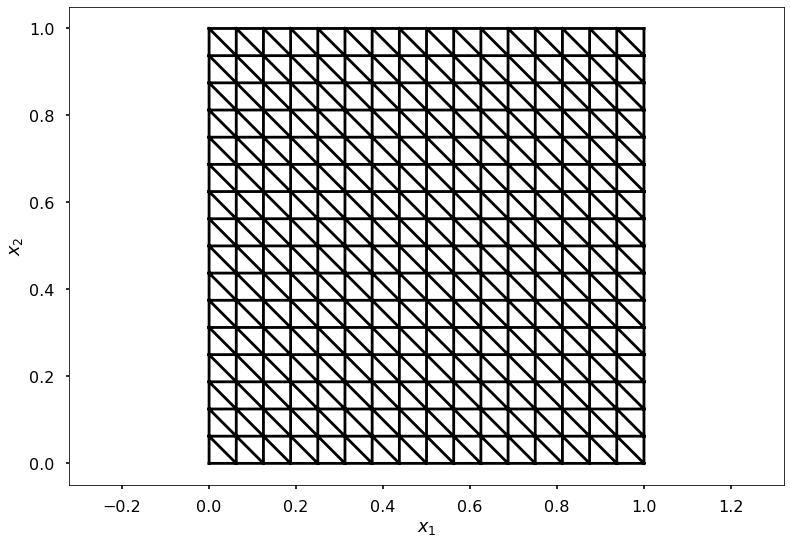

In [4]:
ns = 16
x0 = 0.0
x1 = 1.0
xv, yv, elt2vert, nvtx, ne, h = uniform_mesh_info(x0, x1, ns)   

Compute the solution

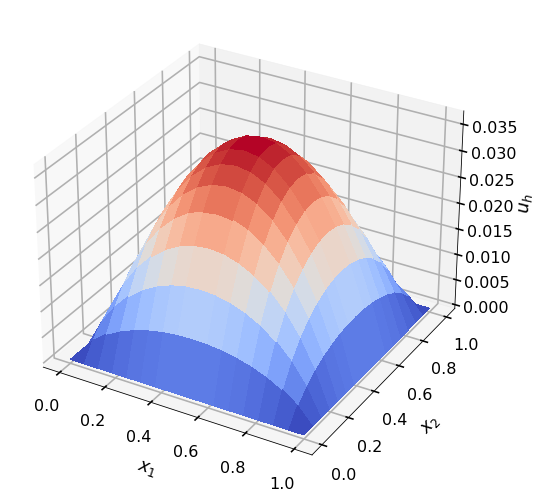

In [5]:
u_int, A_int, rhs = two_dimensional_linear_FEM(ns, xv, yv, elt2vert, x0, x1, nvtx, ne, h, np.ones(ne), np.ones(ne))